## Segmentação de Clientes

#### Feito por: Carolina Tavares Sancho Monteiro

A equipe de Relacionamento com o Cliente (CRM) do Grupo XXX pretende realizar disparos de e-mail marketing e SMS para os clientes de uma das marcas da companhia. O objetivo da ação é estimular uma nova compra dos clientes, sendo a principal métrica de sucesso a “conversão”: clientes que realizaram uma nova compra / total de clientes com quem o time se comunicou.
O time de ciência de dados foi acionado para auxiliar nessa estratégia e você será o encarregado dessa missão! Como orientação, seu (futuro) gestor sugeriu três possíveis estudos:
1. Análise exploratória, para entendermos a base de dados e os padrões de comportamento dos clientes;
2. Segmentação dos clientes.


### Importando as libs e os arquivos da base:

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from yellowbrick.cluster import KElbowVisualizer

In [424]:
df = pd.read_csv('dados.csv', sep=',', low_memory=False)

In [425]:
dfback = df

## 1. EDA
Análise exploratória, para entendermos a base de dados e os padrões de comportamento dos clientes;


In [426]:
df.head()

,MARCA,DATA,ID_CLIENTE,DATA_NASCIMENTO,ORIGEM,VALOR,DESCONTO
0,A,2021-01-01,243376.0,NaN,PDV,46.8,0.0
1,A,2021-01-01,135992.0,NaN,PDV,35.4,0.0
2,A,2021-01-01,974841.0,NaN,PDV,43.8,0.0
3,A,2021-01-01,85793.0,NaN,PDV,62.3,0.0
4,A,2021-01-01,614347.0,1998-02-11,PWA Marca,79.3,0.0


In [427]:
df.columns

Index(['MARCA', 'DATA', 'ID_CLIENTE', 'DATA_NASCIMENTO', 'ORIGEM', 'VALOR',
       'DESCONTO'],
      dtype='object')

In [428]:
df.size

10997903

In [429]:
df.shape

(1571129, 7)

In [430]:
pd.DataFrame(df.dtypes, columns=['Type'])

,Type
MARCA,object
DATA,object
ID_CLIENTE,float64
DATA_NASCIMENTO,object
ORIGEM,object
VALOR,float64
DESCONTO,float64


In [431]:
df.isna().sum()

MARCA                    0
DATA                     0
ID_CLIENTE          300000
DATA_NASCIMENTO    1050509
ORIGEM                   0
VALOR                    0
DESCONTO                 0
dtype: int64

Muitos valores nulos nas colunas ID e Data de nascimento

<AxesSubplot:>

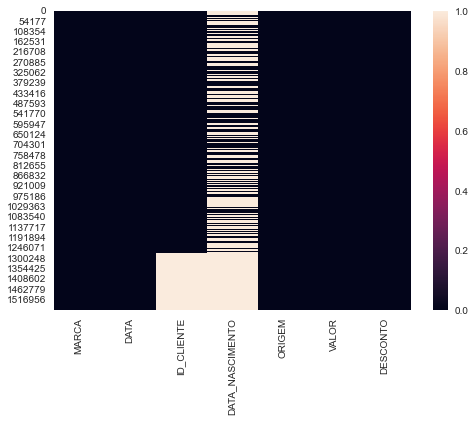

In [432]:
sns.heatmap(df.isnull())

### Análise das colunas:

### - Marca:

In [433]:
df.MARCA.unique()

array(['A'], dtype=object)

In [434]:
df.MARCA.nunique()

1

#### A coluna Marca possui apenas um valor: 'A'e nenhum valor nulo.

### - Data:

In [435]:
df.DATA.value_counts()

2021-12-18    11738
2021-12-20    11197
2021-12-22    11059
2021-12-04    11027
2021-12-23    10980
              ...  
2021-03-29      452
2021-04-04      430
2021-03-28      420
2021-03-27      388
2021-01-01      206
Name: DATA, Length: 365, dtype: int64

Mudando o tipo de int64 para datetime para melhor manipulação:

In [436]:
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

In [437]:
df.DATA.nlargest()

1266675   2021-12-31
1266676   2021-12-31
1266677   2021-12-31
1266678   2021-12-31
1266679   2021-12-31
Name: DATA, dtype: datetime64[ns]

In [438]:
df.DATA.nsmallest()

0   2021-01-01
1   2021-01-01
2   2021-01-01
3   2021-01-01
4   2021-01-01
Name: DATA, dtype: datetime64[ns]

In [439]:
df.groupby(df['DATA'].dt.date).count()

,MARCA,DATA,ID_CLIENTE,DATA_NASCIMENTO,ORIGEM,VALOR,DESCONTO
DATA,,,,,,,
2021-01-01,206,206,21,2,206,206,206
2021-01-02,1069,1069,249,41,1069,1069,1069
2021-01-03,896,896,156,39,896,896,896
2021-01-04,1295,1295,330,89,1295,1295,1295
2021-01-05,1271,1271,276,71,1271,1271,1271
...,...,...,...,...,...,...,...
2021-12-27,9310,9310,8294,3049,9310,9310,9310
2021-12-28,9504,9504,8420,3003,9504,9504,9504
2021-12-29,9632,9632,8599,3287,9632,9632,9632


As datas vão desde o da 01/01/2021 até 31/12/2021, ou seja, todo o ano de 2021: 365 dias

### - Id_Cliente:

In [440]:
df.ID_CLIENTE.nunique()

670177

In [441]:
len(df)

1571129

Menos clientes que o numero de linhas, entao tem várias compras do mesmo cliente

In [442]:
df.ID_CLIENTE.value_counts()

687556.0    155
964788.0    150
348789.0    147
602698.0    134
337855.0    132
           ... 
950032.0      1
497154.0      1
971329.0      1
696603.0      1
406603.0      1
Name: ID_CLIENTE, Length: 670177, dtype: int64

Número máximo de compras foi 155 do cliente com ID 687556

### - Data Nascimento:

In [443]:
df['DATA_NASCIMENTO'] = pd.to_datetime(df['DATA_NASCIMENTO'], format='%Y-%m-%d')

In [444]:
df.DATA_NASCIMENTO.value_counts()

1994-01-14    237
1991-10-17    221
1981-03-30    209
1995-04-17    201
2021-11-27    198
             ... 
1969-05-11      1
2020-09-03      1
2019-08-15      1
1971-02-23      1
1960-02-02      1
Name: DATA_NASCIMENTO, Length: 18983, dtype: int64

In [445]:
df.DATA_NASCIMENTO.nlargest()

1005246   2086-12-15
46953     2082-12-12
473703    2082-12-12
662221    2082-12-12
569821    2082-06-01
Name: DATA_NASCIMENTO, dtype: datetime64[ns]

In [446]:
df.DATA_NASCIMENTO.nsmallest()

178011   1772-09-13
627203   1772-09-13
668207   1772-09-13
733876   1772-09-13
737451   1772-09-13
Name: DATA_NASCIMENTO, dtype: datetime64[ns]

#### Data de nascimento em 2086 e 1772?? Provavelmente foi erro de digitação

### - Origem:

In [447]:
df.ORIGEM.unique()

array(['PDV', 'PWA Marca', 'Agregador', 'Telefone'], dtype=object)

In [448]:
df.ORIGEM.value_counts()

PDV          1458045
Agregador      98727
PWA Marca      13635
Telefone         722
Name: ORIGEM, dtype: int64

In [449]:
def plot_percentage(var, data):
    plt.figure(figsize=(6, 5))
    
    ax = sns.countplot(x=var, data=data, orient='h', palette='Set2', order=data[var].value_counts().index)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(var, fontsize=15)
    sizes = []
    
    for p in ax.patches:
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x() + p.get_width()/1.6, 
                height + 6,
               '{:1.2f}%'.format(height/len(data)*100),
               ha = 'center', va = 'bottom',
               fontsize=9)

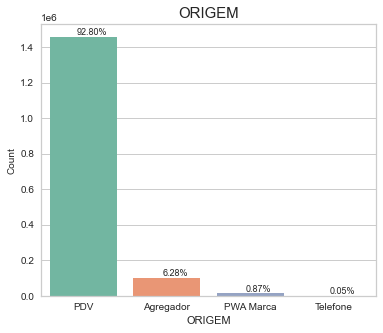

In [450]:
plot_percentage('ORIGEM', df)

#### Para conseguirmos incluir a coluna origem na análise, modificaremos seu tipo de variável de qualitativa para quantitativa através do pd.getdummies

In [451]:
df = pd.get_dummies(df, columns=['ORIGEM'])

In [452]:
df.head()

,MARCA,DATA,ID_CLIENTE,DATA_NASCIMENTO,VALOR,DESCONTO,ORIGEM_Agregador,ORIGEM_PDV,ORIGEM_PWA Marca,ORIGEM_Telefone
0,A,2021-01-01,243376.0,NaT,46.8,0.0,0,1,0,0
1,A,2021-01-01,135992.0,NaT,35.4,0.0,0,1,0,0
2,A,2021-01-01,974841.0,NaT,43.8,0.0,0,1,0,0
3,A,2021-01-01,85793.0,NaT,62.3,0.0,0,1,0,0
4,A,2021-01-01,614347.0,1998-02-11,79.3,0.0,0,0,1,0


### - Valor:

In [453]:
df.VALOR.nlargest()

1559419    2250.20
1280004    2115.65
1509316    1876.90
1566340    1822.60
1376173    1608.70
Name: VALOR, dtype: float64

In [454]:
df.VALOR.nsmallest()

20973     0.01
33856     0.01
214595    0.01
362473    0.01
365194    0.01
Name: VALOR, dtype: float64

In [455]:
df.VALOR.describe()

count    1.571129e+06
mean     4.053858e+01
std      2.266905e+01
min      1.000000e-02
25%      2.600000e+01
50%      3.348000e+01
75%      5.030000e+01
max      2.250200e+03
Name: VALOR, dtype: float64

<AxesSubplot:>

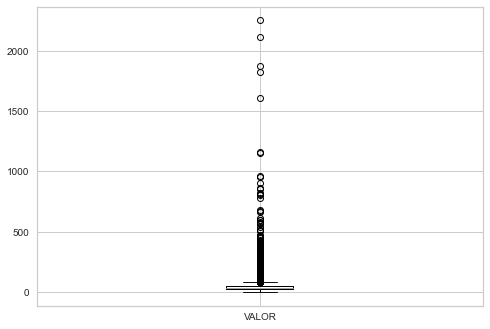

In [456]:
df.boxplot(column='VALOR')

#### Os valores são bem variáveis, apresentando a média em aproximadamente 40,5 e a mediana em 33,5 com uns valores um pouco discrepantes acima de 1500,00 o que está fazendo a média subir.

### - Desconto:

In [457]:
df.DESCONTO.value_counts()

0.00     1413480
3.50        1041
7.00         745
10.50        650
2.99         629
          ...   
55.60          1
65.20          1
27.56          1
60.60          1
69.00          1
Name: DESCONTO, Length: 4686, dtype: int64

In [458]:
df.DESCONTO.value_counts(normalize=True)*100

0.00     89.965878
3.50      0.066258
7.00      0.047418
10.50     0.041372
2.99      0.040035
           ...    
55.60     0.000064
65.20     0.000064
27.56     0.000064
60.60     0.000064
69.00     0.000064
Name: DESCONTO, Length: 4686, dtype: float64

90% das compras foram feitas sem desconto

In [459]:
df.DESCONTO.nlargest()

859896    185.29
614328    172.80
385174    167.90
734167    167.10
473002    150.45
Name: DESCONTO, dtype: float64

In [460]:
df.DESCONTO.nsmallest()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DESCONTO, dtype: float64

In [461]:
df.DESCONTO.describe()

count    1.571129e+06
mean     8.714347e-01
std      3.589594e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.852900e+02
Name: DESCONTO, dtype: float64

<AxesSubplot:>

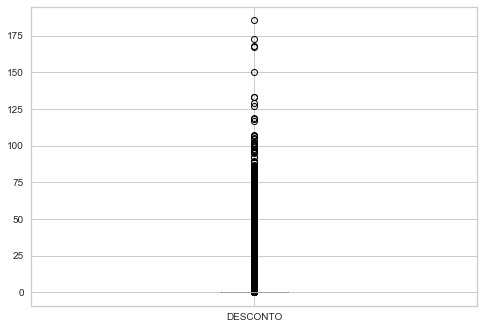

In [462]:
df.boxplot(column='DESCONTO')

Os descontos também são muito variáveis

<AxesSubplot:xlabel='VALOR', ylabel='DESCONTO'>

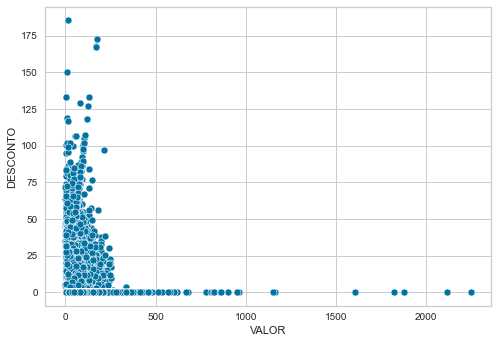

In [463]:
sns.scatterplot(x='VALOR', y='DESCONTO', data=df)

In [464]:
#não dá pra ver direito nesse grafico, vou limitar o valor até 400,00

In [465]:
dfchart = df.loc[(df.VALOR < 400)]

<AxesSubplot:xlabel='VALOR', ylabel='DESCONTO'>

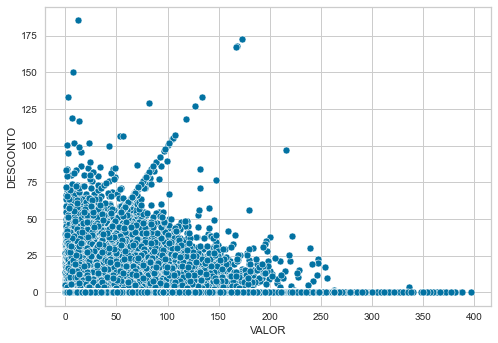

In [466]:
sns.scatterplot(x='VALOR', y='DESCONTO', data=dfchart)

In [467]:
#limitando um pouco mais o valor até 250,00

In [468]:
dfchart = df.loc[(df.VALOR < 250)]

<AxesSubplot:xlabel='VALOR', ylabel='DESCONTO'>

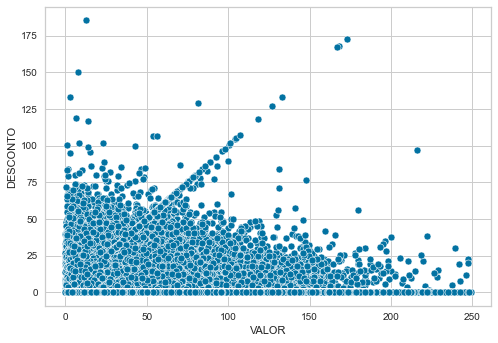

In [469]:
sns.scatterplot(x='VALOR', y='DESCONTO', data=dfchart)

In [470]:
dfback = dfback.loc[(df.VALOR < 250)]

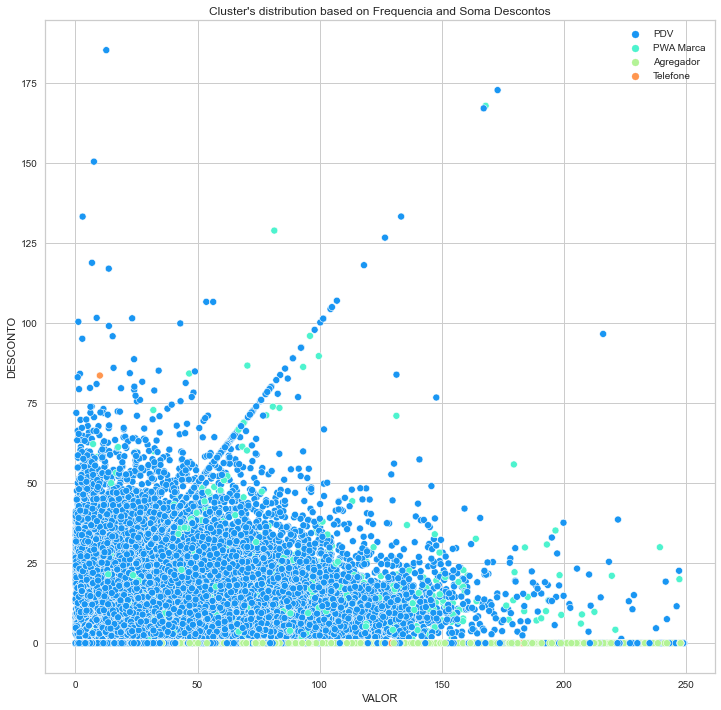

In [471]:
pallete = []
plt.figure(figsize=(12,12))
sct_plot = sns.scatterplot(data=dfback, x=dfback["VALOR"], y=dfback["DESCONTO"], 
                           hue=dfback["ORIGEM"], palette='rainbow')
sct_plot.set_title("Cluster's distribution based on Frequencia and Soma Descontos")
plt.legend()
plt.show()

Apesar da concentração de descontos ser maior onde os valores são menores, a distribuição é bem variável, apresentando alguns descontos altos para valores altos e descontos baixos para o mesmo valor (provavelmente aplicados para diferentes clientes).

Não existe clareza na relação de descontos/valores com origem da compra.

### Criação de novas colunas e tabelas para posterior análise:

### Recency - Há quantos dias compraram o cliente pela última vez?

Considerando o último dia da coluna de DATA como o dia em que os dados foram coletados, calcularei o RECENCY (numero de dias desde a ultima compra) como a diferença desse último dia menos o dia da compra (DATA)

In [472]:
df['RECENCY'] = ((datetime.datetime(2021,12,31) - df.DATA)/np.timedelta64(1,'D'))

In [473]:
df.head()

,MARCA,DATA,ID_CLIENTE,DATA_NASCIMENTO,VALOR,DESCONTO,ORIGEM_Agregador,ORIGEM_PDV,ORIGEM_PWA Marca,ORIGEM_Telefone,RECENCY
0,A,2021-01-01,243376.0,NaT,46.8,0.0,0,1,0,0,364.0
1,A,2021-01-01,135992.0,NaT,35.4,0.0,0,1,0,0,364.0
2,A,2021-01-01,974841.0,NaT,43.8,0.0,0,1,0,0,364.0
3,A,2021-01-01,85793.0,NaT,62.3,0.0,0,1,0,0,364.0
4,A,2021-01-01,614347.0,1998-02-11,79.3,0.0,0,0,1,0,364.0


### Idade - Ano de coleta dos dados - Data nascimento

In [474]:
df['IDADE'] =  df.DATA.dt.year - df.DATA_NASCIMENTO.dt.year

In [475]:
df.IDADE.value_counts()

 27.0     17930
 26.0     17471
 28.0     17450
 40.0     17037
 25.0     16880
          ...  
-65.0         1
 163.0        1
 141.0        1
 153.0        1
-33.0         1
Name: IDADE, Length: 126, dtype: int64

<AxesSubplot:>

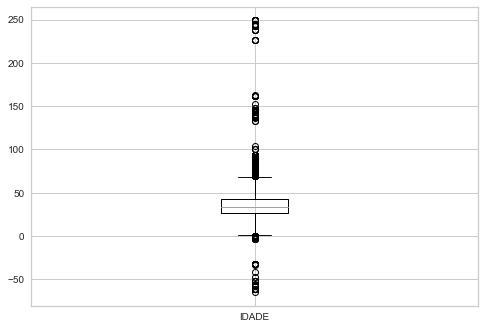

In [476]:
df.boxplot(column='IDADE')

Substituirei as idades <0 e maiores que 100 por NaN para não entrarem na análise, uma vez que provavelmente ali estão por erro de digitação.

In [477]:
mask = ((df.IDADE>=100 ) | (df.IDADE<=0))
df.loc[mask, 'IDADE'] = np.NaN

In [478]:
df.IDADE.value_counts()

27.0    17930
26.0    17471
28.0    17450
40.0    17037
25.0    16880
        ...  
94.0        8
89.0        7
90.0        5
82.0        5
88.0        1
Name: IDADE, Length: 90, dtype: int64

### Agrupando dados:

### Por Id_cliente, criarei novas medidas:

#### - Frequência: Quantas vezes os clientes compraram neste ano?
#### - Valor Total - Quanto gastaram os clientes neste ano? 
#### - Soma Descontos - Quanto de desconto tiveram os clientes?

Considerarei o mínimo de dias da última compra do cliente para Recency, e somarei os valores de origem.

In [479]:
dfpedidos = df.groupby(['ID_CLIENTE']).agg(Frequencia=('ID_CLIENTE','count'), Valor_Total=('VALOR','sum'), Valor_Medio=('VALOR', 'mean'), Soma_Descontos=('DESCONTO', 'sum'), Desconto_Medio=('DESCONTO', 'mean'), Recency=('RECENCY', 'min'), Idade=('IDADE', 'max'), Origem_Agregador =('ORIGEM_Agregador' , 'sum'), Origem_PDV=('ORIGEM_PDV', 'sum'), Origem_PWA=('ORIGEM_PWA Marca', 'sum'), Origem_Telefone = ('ORIGEM_Telefone', 'sum') ).sort_values(by='Frequencia', ascending=False).reset_index()

In [480]:
dfpedidos

,ID_CLIENTE,Frequencia,Valor_Total,Valor_Medio,Soma_Descontos,Desconto_Medio,Recency,Idade,Origem_Agregador,Origem_PDV,Origem_PWA,Origem_Telefone
0,687556.0,155,5429.95,35.031935,899.05,5.800323,4.0,27.0,0,155,0,0
1,964788.0,150,5239.20,34.928000,0.00,0.000000,220.0,24.0,0,150,0,0
2,348789.0,147,7550.32,51.362721,1465.28,9.967891,8.0,47.0,0,147,0,0
3,602698.0,134,2785.72,20.788955,447.58,3.340149,1.0,21.0,0,134,0,0
4,337855.0,132,2360.17,17.880076,393.47,2.980833,1.0,34.0,0,132,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
670172,490780.0,1,23.90,23.900000,0.00,0.000000,94.0,NaN,0,1,0,0
670173,490779.0,1,31.40,31.400000,0.00,0.000000,199.0,35.0,0,1,0,0
670174,490778.0,1,50.30,50.300000,0.00,0.000000,95.0,NaN,0,1,0,0
670175,490776.0,1,23.90,23.900000,0.00,0.000000,10.0,NaN,0,1,0,0


In [481]:
dfpedidosspdv = dfpedidos

In [60]:
dfpedidos.Frequencia.value_counts(normalize=True)

1      0.730065
2      0.128961
3      0.050488
4      0.026427
5      0.015702
         ...   
89     0.000001
83     0.000001
78     0.000001
69     0.000001
155    0.000001
Name: Frequencia, Length: 116, dtype: float64

## 27% dos clientes compraram mais de uma vez no ano de 2021

In [62]:
dfpedidos.Soma_Descontos.value_counts(normalize=True)*100

0.00      94.152739
3.50       0.051181
7.00       0.043869
10.50      0.034319
14.00      0.025963
            ...    
13.23      0.000149
98.14      0.000149
148.13     0.000149
145.20     0.000149
62.28      0.000149
Name: Soma_Descontos, Length: 13394, dtype: float64

## 6% dos clientes compraram com desconto em 2021

In [63]:
df.ID_CLIENTE.nunique()

670177

A tabela dfpedidos está com o mesmo número de clientes da tabela original

In [64]:
dfpedidos.columns

Index(['ID_CLIENTE', 'Frequencia', 'Valor_Total', 'Valor_Medio',
       'Soma_Descontos', 'Desconto_Medio', 'Recency', 'Idade',
       'Origem_Agregador', 'Origem_PDV', 'Origem_PWA', 'Origem_Telefone'],
      dtype='object')

In [65]:
dfpedidos.describe()

,ID_CLIENTE,Frequencia,Valor_Total,Valor_Medio,Soma_Descontos,Desconto_Medio,Recency,Idade,Origem_Agregador,Origem_PDV,Origem_PWA,Origem_Telefone
count,670177.000000,670177.000000,670177.000000,670177.000000,670177.000000,670177.000000,670177.000000,106052.000000,670177.000000,670177.000000,670177.000000,670177.000000
mean,570667.549277,1.896706,76.119387,41.475548,2.042937,0.184996,92.008402,35.184428,0.003213,1.872435,0.020289,0.000770
std,283619.476159,3.105711,119.863256,20.602625,15.761755,0.939903,77.554493,11.116062,0.167907,3.069301,0.391675,0.072592
min,1.000000,1.000000,0.010000,0.010000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,340955.000000,1.000000,30.200000,28.150000,0.000000,0.000000,25.000000,27.000000,0.000000,1.000000,0.000000,0.000000
50%,604233.000000,1.000000,43.800000,34.900000,0.000000,0.000000,64.000000,34.000000,0.000000,1.000000,0.000000,0.000000
75%,818968.000000,2.000000,75.400000,51.000000,0.000000,0.000000,158.000000,42.000000,0.000000,2.000000,0.000000,0.000000
max,1000000.000000,155.000000,7550.320000,1161.200000,1465.280000,61.550000,364.000000,94.000000,79.000000,155.000000,65.000000,35.000000


In [201]:
dfpedidos

,ID_CLIENTE,Frequencia,Valor_Total,Valor_Medio,Soma_Descontos,Desconto_Medio,Recency,Idade,Origem_Agregador,Origem_PDV,Origem_PWA,Origem_Telefone,Cluster_Name
0,687556.0,155,5429.95,35.031935,899.05,5.800323,4.0,27.0,0,155,0,0,Melhores_Clientes
1,964788.0,150,5239.20,34.928000,0.00,0.000000,220.0,24.0,0,150,0,0,Melhores_Clientes
2,348789.0,147,7550.32,51.362721,1465.28,9.967891,8.0,47.0,0,147,0,0,Melhores_Clientes
3,602698.0,134,2785.72,20.788955,447.58,3.340149,1.0,21.0,0,134,0,0,Melhores_Clientes
4,337855.0,132,2360.17,17.880076,393.47,2.980833,1.0,34.0,0,132,0,0,Melhores_Clientes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
670172,490780.0,1,23.90,23.900000,0.00,0.000000,94.0,NaN,0,1,0,0,Uma_Compra
670173,490779.0,1,31.40,31.400000,0.00,0.000000,199.0,35.0,0,1,0,0,Uma_Compra
670174,490778.0,1,50.30,50.300000,0.00,0.000000,95.0,NaN,0,1,0,0,Uma_Compra
670175,490776.0,1,23.90,23.900000,0.00,0.000000,10.0,NaN,0,1,0,0,Uma_Compra


C:\Users\carol\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Idade'>

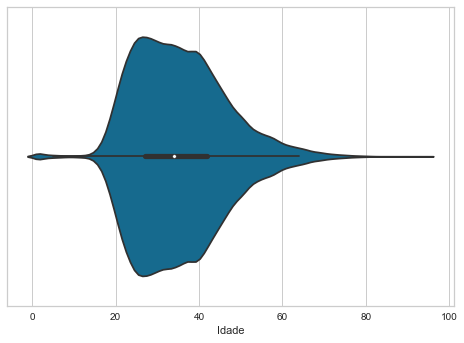

In [66]:
sns.violinplot('Idade', data=dfpedidos)

<AxesSubplot:>

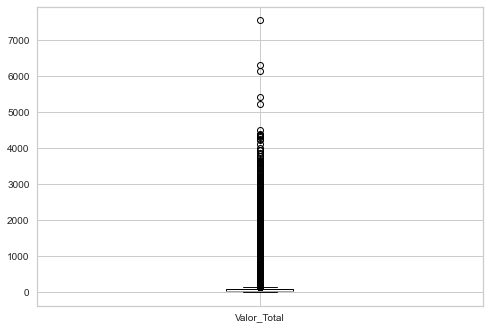

In [67]:
dfpedidos.boxplot(column='Valor_Total')

<AxesSubplot:>

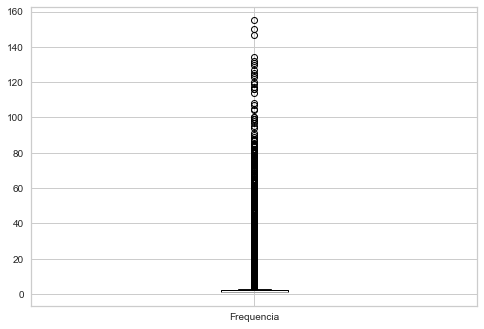

In [68]:
dfpedidos.boxplot(column='Frequencia')

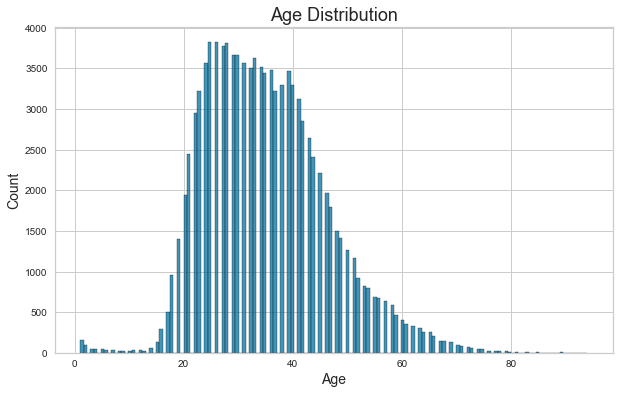

In [69]:
plt.figure(figsize=(10,6))
sns.histplot(dfpedidos.Idade)
plt.title('Age Distribution',size=18)
plt.xlabel('Age',size=14)
plt.ylabel('Count',size=14)
plt.show()

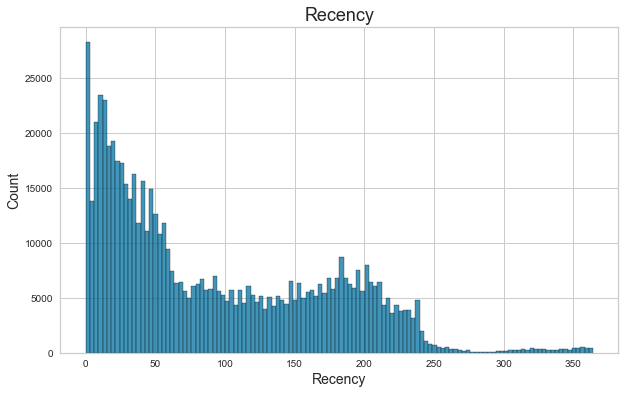

In [70]:
plt.figure(figsize=(10,6))
sns.histplot(dfpedidos.Recency)
plt.title('Recency',size=18)
plt.xlabel('Recency',size=14)
plt.ylabel('Count',size=14)
plt.show()

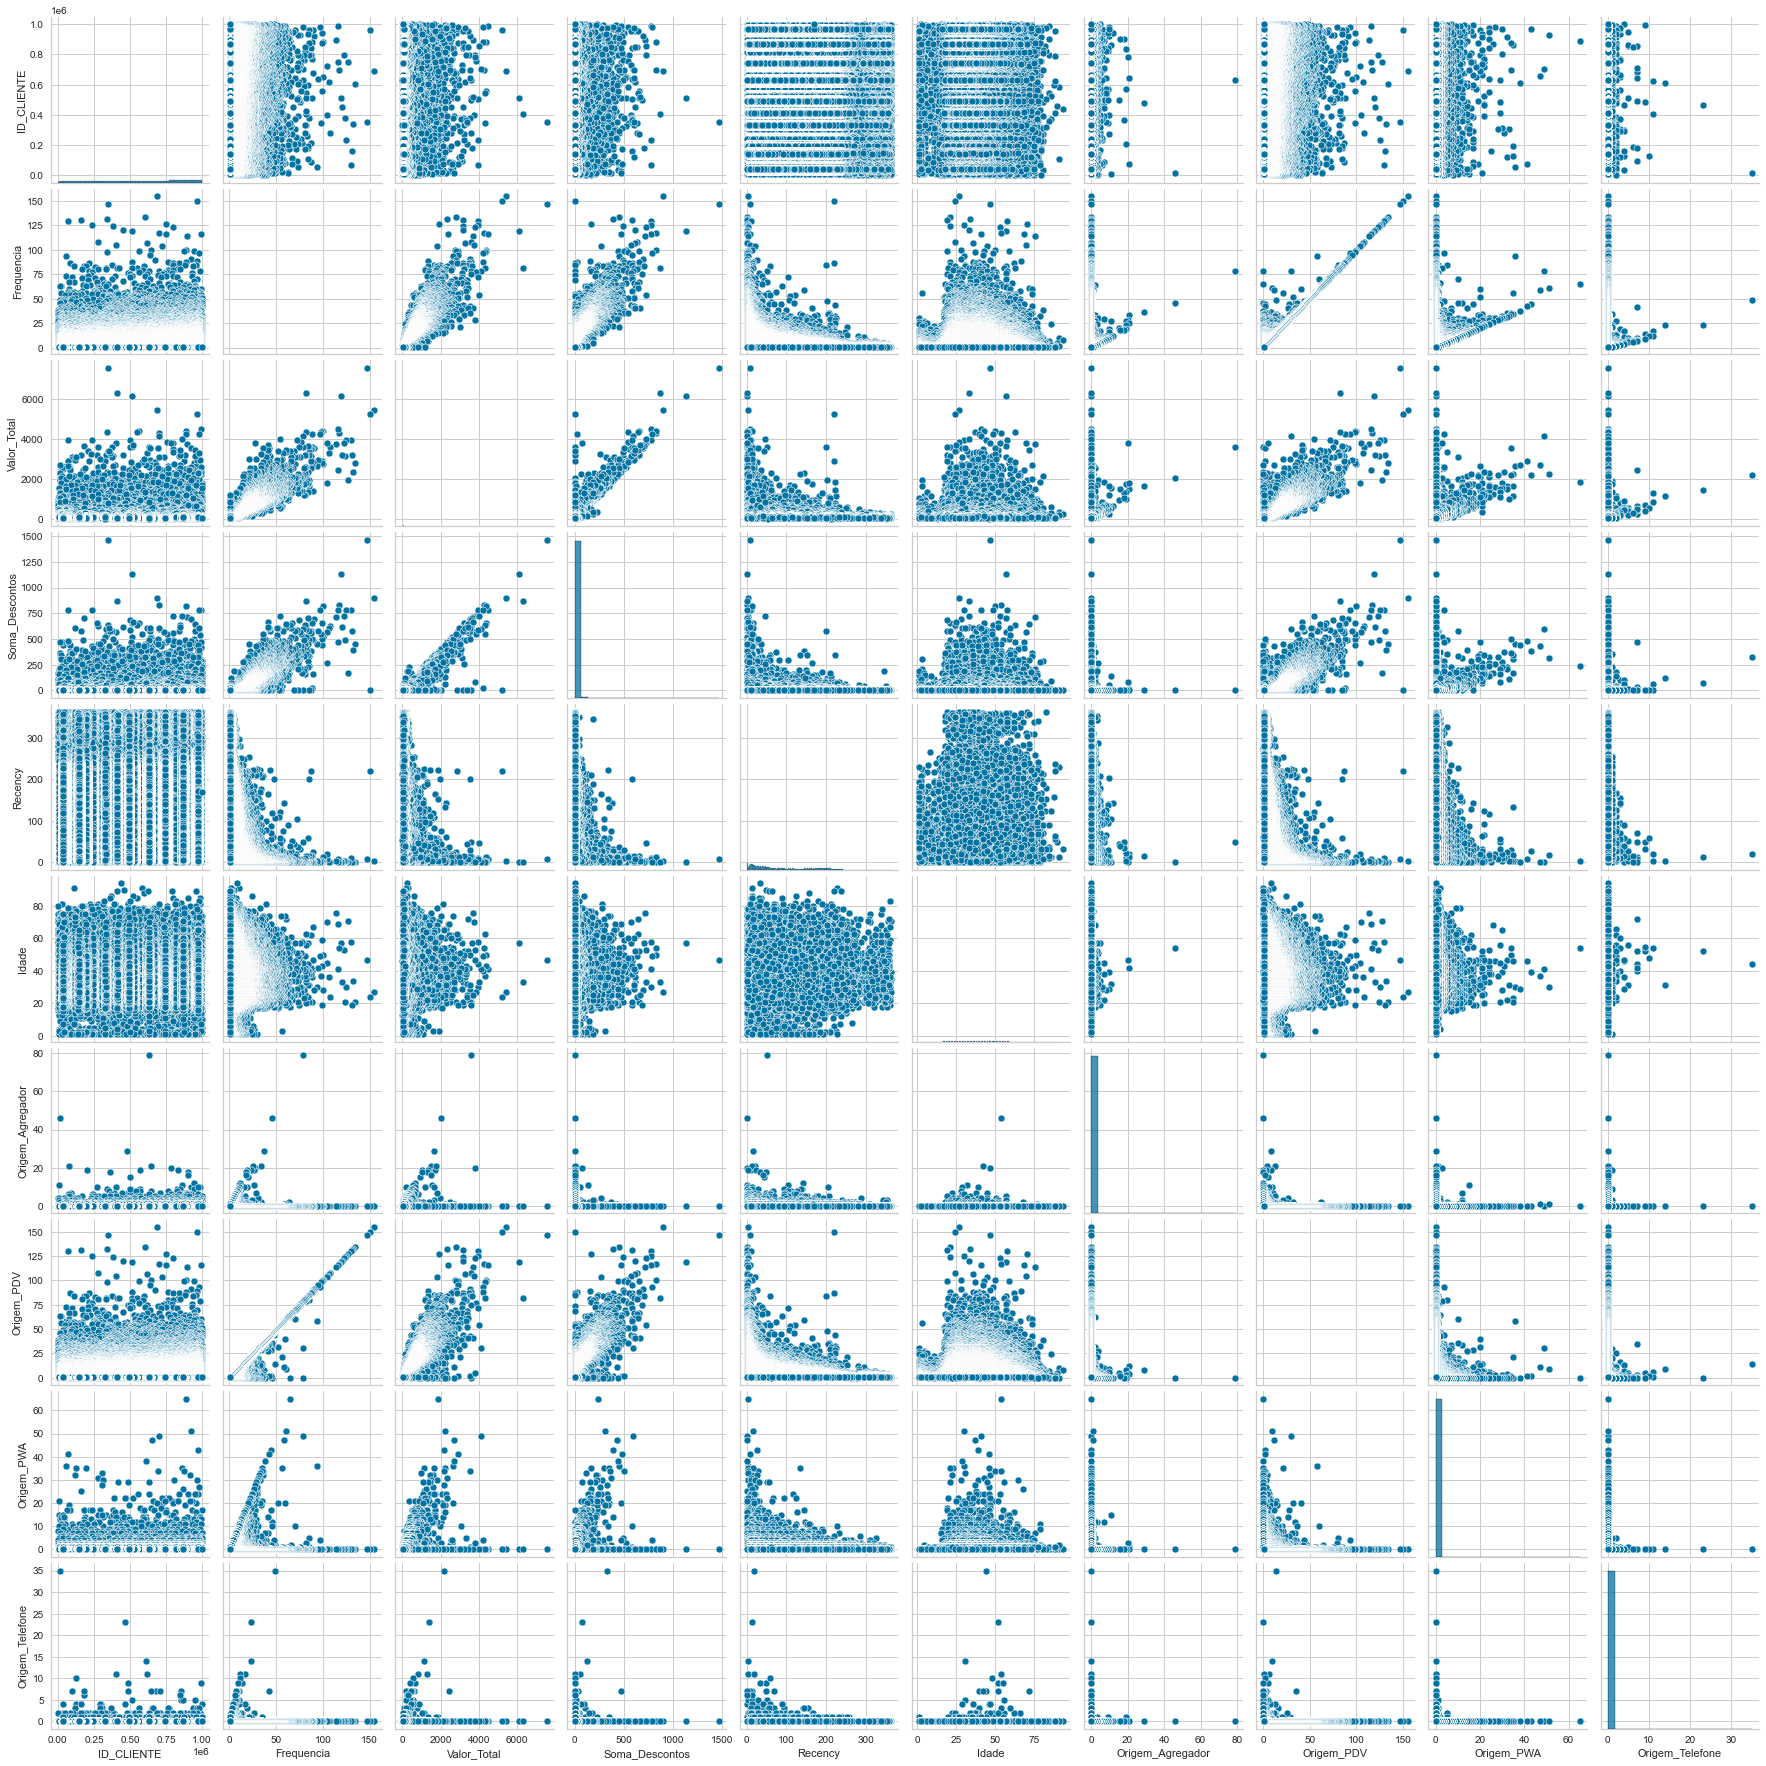

In [70]:
sns.pairplot(dfpedidos)

## 2. Customer Segmentation

Análise de correlação: uma forma descritiva que mede se há e qual o grau de dependência entre variáveis, ou seja, o quanto uma variável interfere em outra.

In [422]:
dfpedidos.corr()

,ID_CLIENTE,Frequencia,Valor_Total,Valor_Medio,Soma_Descontos,Desconto_Medio,Recency,Idade,Origem_Agregador,Origem_PDV,Origem_PWA,Origem_Telefone
ID_CLIENTE,1.000000,0.002175,0.001383,-0.001900,0.002572,0.001183,-0.002238,0.000366,0.000487,0.002234,0.000030,-0.002714
Frequencia,0.002175,1.000000,0.897691,-0.039814,0.836387,0.579657,-0.194657,0.054391,0.053286,0.990172,0.141822,0.028640
Valor_Total,0.001383,0.897691,1.000000,0.219786,0.842031,0.628450,-0.199404,0.101973,0.078144,0.879185,0.187348,0.041111
Valor_Medio,-0.001900,-0.039814,0.219786,1.000000,0.000464,0.020893,-0.028637,0.131826,0.013549,-0.044688,0.027119,0.008421
Soma_Descontos,0.002572,0.836387,0.842031,0.000464,1.000000,0.676397,-0.114488,0.068818,0.004274,0.821666,0.186214,0.027298
Desconto_Medio,0.001183,0.579657,0.628450,0.020893,0.676397,1.000000,-0.126284,0.066459,0.002373,0.564218,0.171327,0.013627
Recency,-0.002238,-0.194657,-0.199404,-0.028637,-0.114488,-0.126284,1.000000,0.002600,-0.005851,-0.195130,-0.010905,-0.005261
Idade,0.000366,0.054391,0.101973,0.131826,0.068818,0.066459,0.002600,1.000000,0.004558,0.052314,0.013625,0.011928
Origem_Agregador,0.000487,0.053286,0.078144,0.013549,0.004274,0.002373,-0.005851,0.004558,1.000000,-0.002465,0.012464,0.003714
Origem_PDV,0.002234,0.990172,0.879185,-0.044688,0.821666,0.564218,-0.195130,0.052314,-0.002465,1.000000,0.015174,0.004921


Text(0.5, 1.0, 'Features Correlating with Numero_Pedidos')

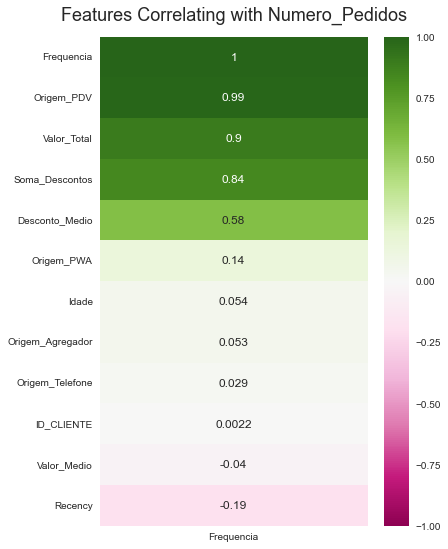

In [72]:
plt.figure(figsize=(6, 9))
heatmap = sns.heatmap(dfpedidos.corr()[['Frequencia']].sort_values(by='Frequencia', ascending=False), vmin=-1, vmax=1, annot=True, cmap='PiYG')
heatmap.set_title('Features Correlating with Numero_Pedidos', fontdict={'fontsize':18}, pad=16)

#### As variáveis com cor verde escuro possuem uma forte correlação, serão então as que consideraremos para fazer a segmentação de clientes.

In [40]:
#Pessoas que compram mais $$ tendem a pedir mais e pessoas com mais descontos tambem tendem a pedir mais - não ha correlaçao com idade

In [73]:
dfcluster = dfpedidos[['Frequencia', 'Valor_Total', 'Valor_Medio', 'Desconto_Medio','Soma_Descontos', 'Origem_PDV', 'Origem_Agregador']]

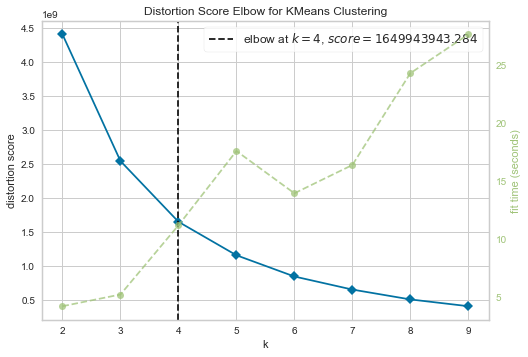

In [74]:
plt_elb = KElbowVisualizer(KMeans(random_state=42), k=(2,10), metric='distortion')
plt_elb.fit(dfcluster)
plt_elb.show();

In [74]:
#lets make with 4 clusters:

kmeans = KMeans(n_clusters = 4)
kmeans

KMeans(n_clusters=4)

In [75]:
kmeans.fit(dfcluster)

KMeans(n_clusters=4)

In [76]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0])

In [77]:
kmeans.predict(dfcluster)

array([1, 1, 1, ..., 0, 0, 0])

In [78]:
dfcluster['Cluster'] = kmeans.labels_

C:\Users\carol\AppData\Local\Temp/ipykernel_4792/42468799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcluster['Cluster'] = kmeans.labels_


In [79]:
dfcluster

,Frequencia,Valor_Total,Valor_Medio,Desconto_Medio,Soma_Descontos,Origem_PDV,Origem_Agregador,Cluster
0,155,5429.95,35.031935,5.800323,899.05,155,0,1
1,150,5239.20,34.928000,0.000000,0.00,150,0,1
2,147,7550.32,51.362721,9.967891,1465.28,147,0,1
3,134,2785.72,20.788955,3.340149,447.58,134,0,1
4,132,2360.17,17.880076,2.980833,393.47,132,0,1
...,...,...,...,...,...,...,...,...
670172,1,23.90,23.900000,0.000000,0.00,1,0,0
670173,1,31.40,31.400000,0.000000,0.00,1,0,0
670174,1,50.30,50.300000,0.000000,0.00,1,0,0
670175,1,23.90,23.900000,0.000000,0.00,1,0,0


In [80]:
dfcluster.Cluster.value_counts()

0    591347
3     66849
2     10756
1      1225
Name: Cluster, dtype: int64

In [82]:
dfcluster.Cluster.value_counts(normalize=True)*100

0    88.237436
3     9.974828
2     1.604949
1     0.182788
Name: Cluster, dtype: float64

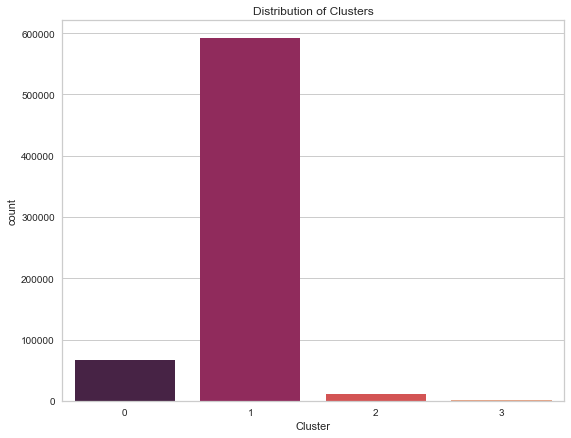

In [196]:
plt.figure(figsize=(9,7))
bar_plot = sns.countplot(x=dfcluster["Cluster"], palette='rocket')
bar_plot.set_title("Distribution of Clusters")
plt.show()

In [197]:
dfcluster.groupby('Cluster').mean()

,Frequencia,Valor_Total,Valor_Medio,Desconto_Medio,Soma_Descontos,Origem_PDV,Origem_Agregador
Cluster,,,,,,,
0,4.768104,207.072732,54.564941,0.827869,5.517252,4.692262,0.011429
1,1.245140,47.973114,39.864572,0.035165,0.088129,1.236080,0.001189
2,15.673485,626.899763,47.652840,3.646529,59.585864,15.327352,0.031889
3,38.768980,1680.951992,50.610536,7.037108,250.845494,37.042449,0.280000


### Nomeando os clusters:

#### Cluster 1: Compraram apenas uma vez, possuem uma média de valor baixa e quase não compraram com desconto;

#### Cluster 0: São clientes com uma frequência baixa de compra, porém já compraram mais de uma vez. Possuem uma média  de compra mais alta que o cluster 0 e de desconto é baixa comparada aos cluster 2 e 3;

#### Cluster 3: São os clientes mais fiéis, com a maior frequência e maiores descontos, com a média de compra um pouco mais baixa que o cluster 3;

#### Cluster 2 : Bons clientes. Possuem uma frequência de compra boa, média de valor de compra um pouco mas alta e media de descontos também mais alta em relação ao cluster 0 e 1. 

In [198]:
clusterdict = {1:'Uma_Compra',  0:'Baixa_Frequencia', 3:'Melhores_Clientes', 2:'Bons_Clientes'}
dfcluster['Cluster_Name'] = dfcluster['Cluster'].replace(clusterdict, regex=True)

C:\Users\carol\AppData\Local\Temp/ipykernel_6320/3087435066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcluster['Cluster_Name'] = dfcluster['Cluster'].replace(clusterdict, regex=True)


In [199]:
dfcluster

,Frequencia,Valor_Total,Valor_Medio,Desconto_Medio,Soma_Descontos,Origem_PDV,Origem_Agregador,Cluster,Cluster_Name
0,155,5429.95,35.031935,5.800323,899.05,155,0,3,Melhores_Clientes
1,150,5239.20,34.928000,0.000000,0.00,150,0,3,Melhores_Clientes
2,147,7550.32,51.362721,9.967891,1465.28,147,0,3,Melhores_Clientes
3,134,2785.72,20.788955,3.340149,447.58,134,0,3,Melhores_Clientes
4,132,2360.17,17.880076,2.980833,393.47,132,0,3,Melhores_Clientes
...,...,...,...,...,...,...,...,...,...
670172,1,23.90,23.900000,0.000000,0.00,1,0,1,Uma_Compra
670173,1,31.40,31.400000,0.000000,0.00,1,0,1,Uma_Compra
670174,1,50.30,50.300000,0.000000,0.00,1,0,1,Uma_Compra
670175,1,23.90,23.900000,0.000000,0.00,1,0,1,Uma_Compra


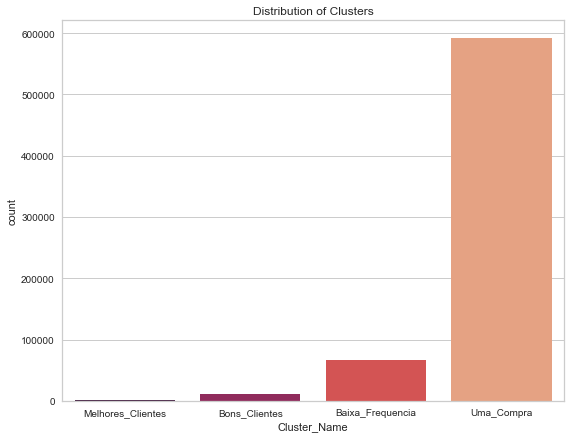

In [200]:
plt.figure(figsize=(9,7))
bar_plot = sns.countplot(x=dfcluster["Cluster_Name"], palette='rocket')
bar_plot.set_title("Distribution of Clusters")
plt.show()

O cluster de "Uma_compra" possui uma quantidade muito maior de clientes.

In [86]:
dfcluster['Valor_Total'].sum()

51013462.09999998

<AxesSubplot:xlabel='Cluster_Name', ylabel='Valor_Total'>

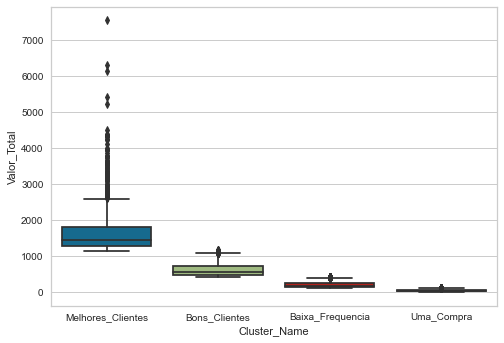

In [166]:
sns.boxplot(x=dfcluster['Cluster_Name'], y=dfcluster['Valor_Total'])

Clusters:

- Melhores Clientes: Possuem uma média de compra semelhante aos outros clusters porém um valor total muito superior devido a sua alta frequência, apresentando também muitos valores dispersos;
- Bons Clientes: Média de compras semelhantes também porém valor total um pouco abaixo do primeiro;
- Baixa Frequencia: Média semelhante e valor total baixo (baixa frequencia);
- Uma Compra: Como compraram basicamente uma vez, possui o valor total de compra semelhante à média.

<AxesSubplot:xlabel='Cluster_Name', ylabel='Valor_Medio'>

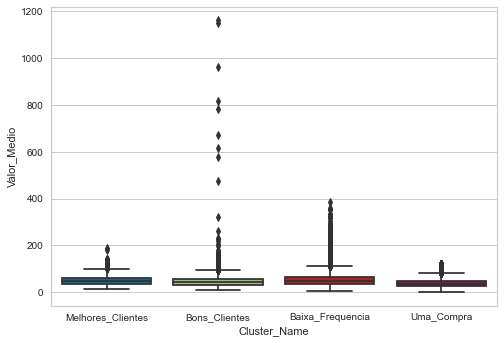

In [162]:
sns.boxplot(x=dfcluster['Cluster_Name'], y=dfcluster['Valor_Medio'])

<AxesSubplot:xlabel='Cluster_Name', ylabel='Frequencia'>

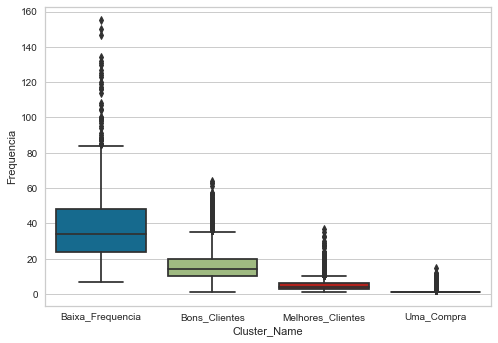

In [90]:
sns.boxplot(x=dfcluster['Cluster_Name'], y=dfcluster['Frequencia'])

<AxesSubplot:xlabel='Cluster_Name', ylabel='Soma_Descontos'>

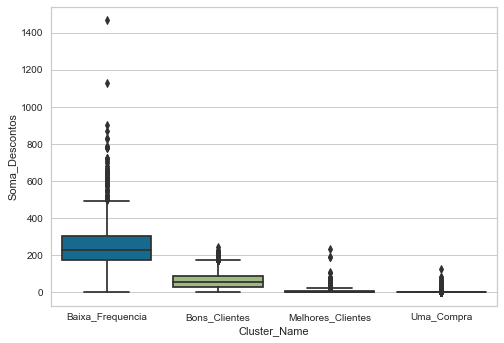

In [91]:
sns.boxplot(x=dfcluster['Cluster_Name'], y=dfcluster['Soma_Descontos'])

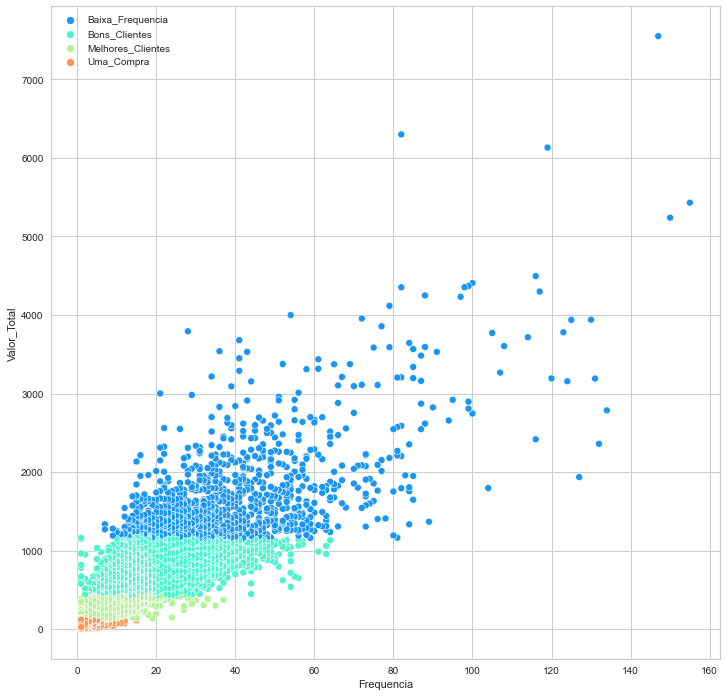

In [92]:
pallete = []
plt.figure(figsize=(12,12))
sct_plot = sns.scatterplot(data=dfcluster, x=dfcluster["Frequencia"], y=dfcluster["Valor_Total"], 
                           hue=dfcluster["Cluster_Name"], palette='rainbow')
bar_plot.set_title("Cluster's distribution based on Frequencia and Valor Total")
plt.legend()
plt.show()

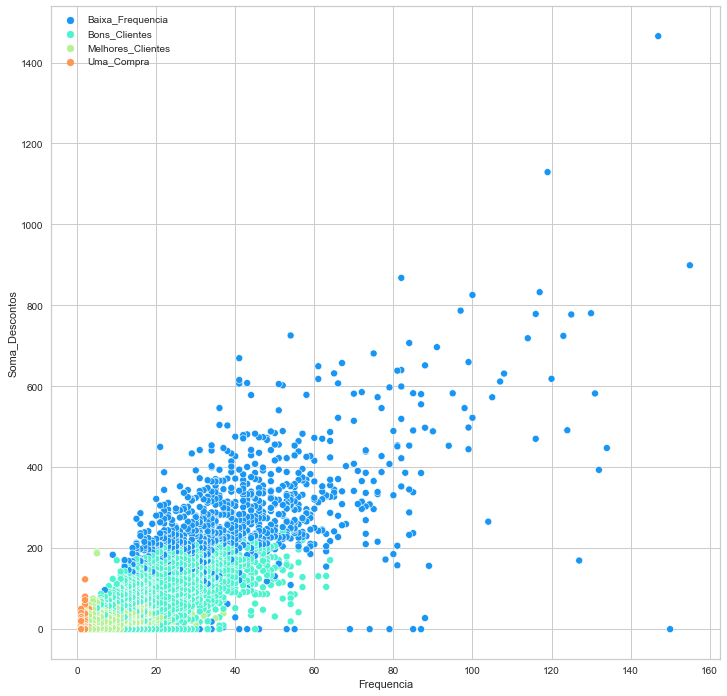

In [93]:
pallete = []
plt.figure(figsize=(12,12))
sct_plot = sns.scatterplot(data=dfcluster, x=dfcluster["Frequencia"], y=dfcluster["Soma_Descontos"], 
                           hue=dfcluster["Cluster_Name"], palette='rainbow')
bar_plot.set_title("Cluster's distribution based on IFrequencia and Soma Descontos")
plt.legend()
plt.show()

In [202]:
dfpedidos = pd.concat([dfpedidos, dfcluster.Cluster_Name], axis=1)

In [208]:
dfpedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670177 entries, 0 to 670176
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID_CLIENTE        670177 non-null  int32  
 1   Frequencia        670177 non-null  int64  
 2   Valor_Total       670177 non-null  float64
 3   Valor_Medio       670177 non-null  float64
 4   Soma_Descontos    670177 non-null  float64
 5   Desconto_Medio    670177 non-null  float64
 6   Recency           670177 non-null  int32  
 7   Idade             106052 non-null  float64
 8   Origem_Agregador  670177 non-null  uint8  
 9   Origem_PDV        670177 non-null  uint8  
 10  Origem_PWA        670177 non-null  uint8  
 11  Origem_Telefone   670177 non-null  uint8  
 12  Cluster_Name      670177 non-null  object 
 13  Cluster_Name      670177 non-null  object 
dtypes: float64(5), int32(2), int64(1), object(2), uint8(4)
memory usage: 48.6+ MB


In [204]:
dfpedidos['ID_CLIENTE'] = dfpedidos.ID_CLIENTE.astype(int)

In [205]:
dfpedidos['Recency'] = dfpedidos.Recency.astype(int)

In [206]:
dfpedidos['Recency'] = dfpedidos.Recency.astype(int)

In [207]:
dfpedidos

,ID_CLIENTE,Frequencia,Valor_Total,Valor_Medio,Soma_Descontos,Desconto_Medio,Recency,Idade,Origem_Agregador,Origem_PDV,Origem_PWA,Origem_Telefone,Cluster_Name,Cluster_Name
0,687556,155,5429.95,35.031935,899.05,5.800323,4,27.0,0,155,0,0,Melhores_Clientes,Melhores_Clientes
1,964788,150,5239.20,34.928000,0.00,0.000000,220,24.0,0,150,0,0,Melhores_Clientes,Melhores_Clientes
2,348789,147,7550.32,51.362721,1465.28,9.967891,8,47.0,0,147,0,0,Melhores_Clientes,Melhores_Clientes
3,602698,134,2785.72,20.788955,447.58,3.340149,1,21.0,0,134,0,0,Melhores_Clientes,Melhores_Clientes
4,337855,132,2360.17,17.880076,393.47,2.980833,1,34.0,0,132,0,0,Melhores_Clientes,Melhores_Clientes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670172,490780,1,23.90,23.900000,0.00,0.000000,94,NaN,0,1,0,0,Uma_Compra,Uma_Compra
670173,490779,1,31.40,31.400000,0.00,0.000000,199,35.0,0,1,0,0,Uma_Compra,Uma_Compra
670174,490778,1,50.30,50.300000,0.00,0.000000,95,NaN,0,1,0,0,Uma_Compra,Uma_Compra
670175,490776,1,23.90,23.900000,0.00,0.000000,10,NaN,0,1,0,0,Uma_Compra,Uma_Compra


In [93]:
dfpedidos.columns

Index(['ID_CLIENTE', 'Frequencia', 'Valor_Total', 'Soma_Descontos', 'Recency',
       'Idade', 'Origem_Agregador', 'Origem_PDV', 'Origem_PWA',
       'Origem_Telefone', 'Cluster_Name'],
      dtype='object')

In [91]:
dfpedidos.to_csv('dfpedidos.csv',sep=';')